In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set()

# Data understanding

## Reading the data

In [112]:
cars_test = pd.read_csv("test.csv")
cars_test_copy = cars_test.copy()

cars_test.head(5)

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


## Meta deta

| **Attribute**       | **Description** |
|----------------------|-----------------|
| **carID**            | An attribute that contains an identifier for each car. |
| **Brand**            | The car’s main brand (e.g. Ford, Toyota). |
| **model**            | The car model. |
| **year**             | The year of registration of the car. |
| **mileage**          | The total reported distance travelled by the car (in miles). |
| **tax**              | The amount of road tax (in £) that, in 2020, was applicable to the car in question. |
| **fuelType**         | Type of fuel used by the car (Diesel, Petrol, Hybrid, Electric). |
| **mpg**              | Average miles per gallon. |
| **engineSize**       | Size of engine in liters (cubic decimeters). |
| **paintQuality%**    | The mechanic’s assessment of the car’s overall paint quality and hull integrity (filled by the mechanic during evaluation). |
| **previousOwners**   | Number of previous registered owners of the vehicle. |
| **hasDamage**        | Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not. |
| **price**            | The car’s price when purchased by Cars 4 You (in £). |


In [113]:
cars_test.duplicated("carID").sum()

np.int64(0)

In [114]:
cars_test.set_index("carID", inplace=True)

In [115]:
cars_test

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105775,VW,Tiguan,2017.000000,Manual,27575.000000,Petrol,145.0,46.3,1.4,94.0,1.0,0.0
81363,BMW,X2,2020.000000,Automatic,1980.000000,Petrol,145.0,34.0,2.0,39.0,3.0,0.0
76833,Audi,Q5,2019.000000,Semi-Auto,8297.000000,Diesel,145.0,38.2,2.0,88.0,4.0,0.0


In [116]:
cars_test.shape

(32567, 12)

In [117]:
cars_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32567 entries, 89856 to 99627
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           31918 non-null  object 
 1   model           31917 non-null  object 
 2   year            31914 non-null  float64
 3   transmission    31944 non-null  object 
 4   mileage         31878 non-null  float64
 5   fuelType        31911 non-null  object 
 6   tax             29259 non-null  float64
 7   mpg             29279 non-null  float64
 8   engineSize      31939 non-null  float64
 9   paintQuality%   31942 non-null  float64
 10  previousOwners  31970 non-null  float64
 11  hasDamage       31970 non-null  float64
dtypes: float64(8), object(4)
memory usage: 3.2+ MB


In [133]:
cars_test

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105775,VW,Tiguan,2017.000000,Manual,27575.000000,Petrol,145.0,46.3,1.4,94.0,1.0,0.0
81363,BMW,X2,2020.000000,Automatic,1980.000000,Petrol,145.0,34.0,2.0,39.0,3.0,0.0
76833,Audi,Q5,2019.000000,Semi-Auto,8297.000000,Diesel,145.0,38.2,2.0,88.0,4.0,0.0


In [132]:
cars_test.columns

Index(['Brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage'],
      dtype='object')

## Metric vs non metric features

In [144]:
metric_features = ['year', 'mileage','tax','mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
non_metric_features = cars_test.columns.drop(metric_features).to_list()

## Missing Values

### Strange Values

In [172]:
cars_test.describe().T

,count,mean,std,min,25%,50%,75%,max
year,31914.0,2017.102299,2.207969,1991.000000,2016.0,2017.0,2019.00,2024.121759
mileage,31878.0,23453.888388,21600.878446,1.000000,7500.0,17500.0,32974.75,279000.000000
tax,29259.0,120.569239,65.560570,-91.121630,125.0,145.0,145.00,580.000000
mpg,29279.0,55.210728,17.644635,-43.421768,46.3,54.3,62.80,470.800000
engineSize,31939.0,1.665377,0.574467,-0.103493,1.2,1.6,2.00,6.600000
paintQuality%,31942.0,64.446667,21.142188,1.638913,47.0,65.0,82.00,125.594308
previousOwners,31970.0,2.006118,1.472310,-2.345650,1.0,2.0,3.00,6.258371
hasDamage,31970.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000


#### Retify negative values

In [ ]:
cars_test["mileage"] = cars_test["mileage"].abs()

In [173]:
cars_test

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
106581,VW,Tiguan,2017.000000,Semi-Auto,48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105775,VW,Tiguan,2017.000000,Manual,27575.000000,Petrol,145.0,46.3,1.4,94.0,1.0,0.0
81363,BMW,X2,2020.000000,Automatic,1980.000000,Petrol,145.0,34.0,2.0,39.0,3.0,0.0
76833,Audi,Q5,2019.000000,Semi-Auto,8297.000000,Diesel,145.0,38.2,2.0,88.0,4.0,0.0


### Numerical features

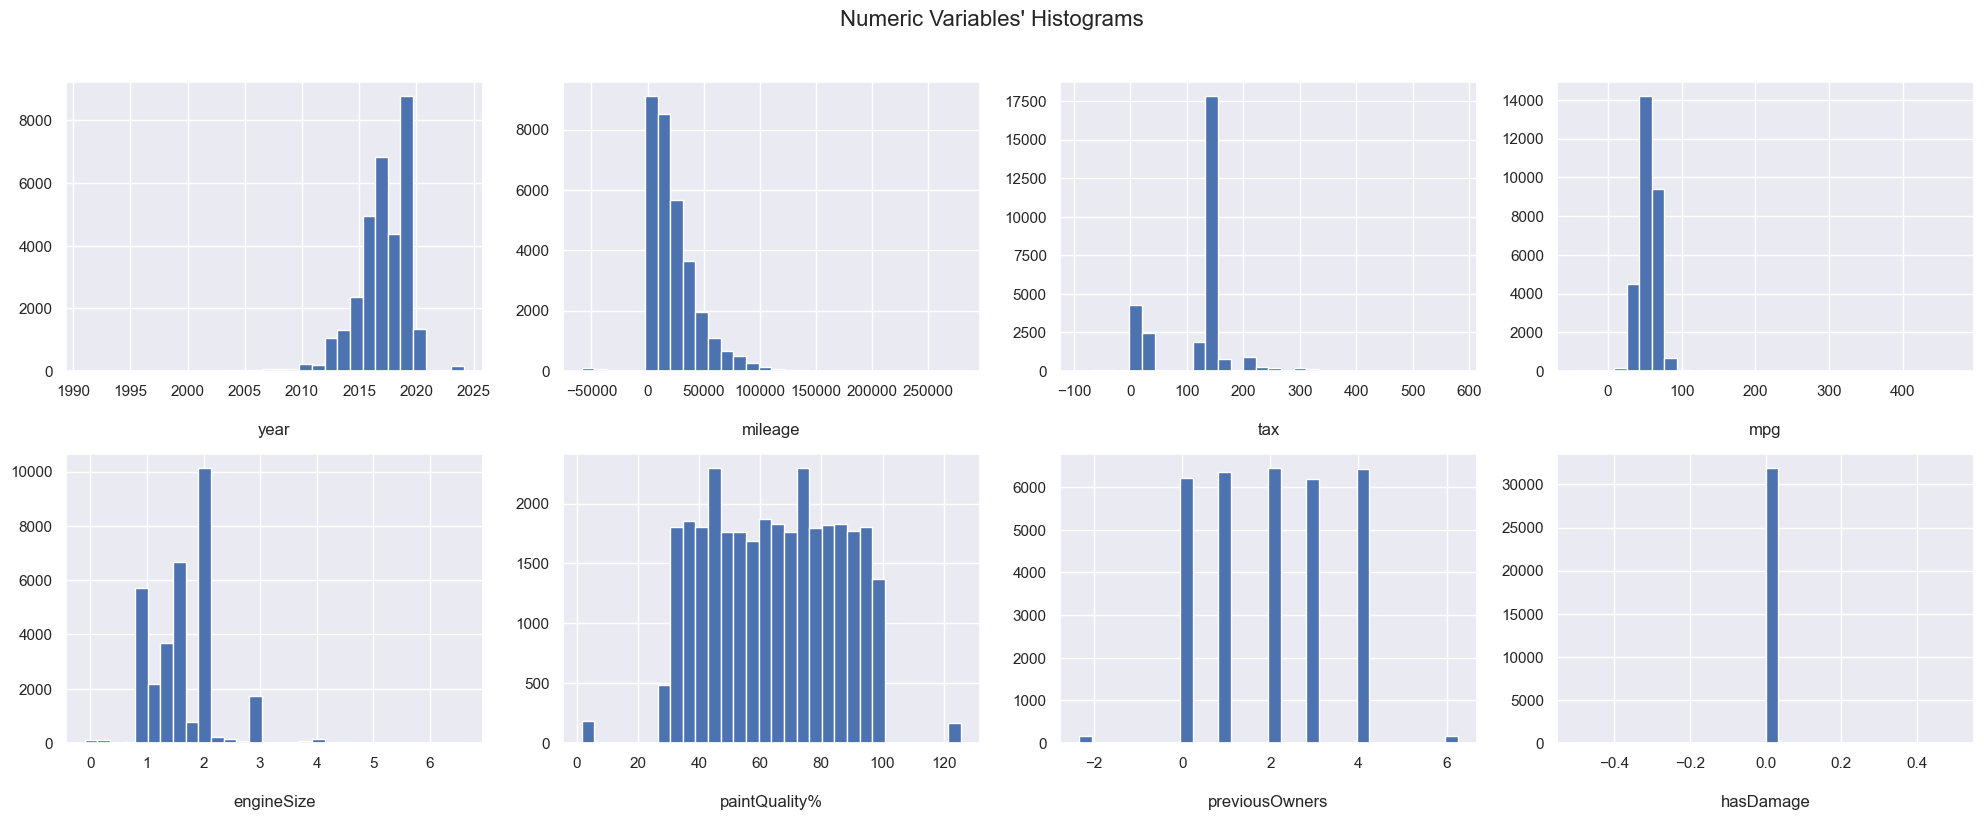

In [164]:
import matplotlib.pyplot as plt

sp_rows = 2
sp_cols = 4

# Prepare figure and axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 8), tight_layout=True)

# Plot data
features = [f for f in metric_features]

for ax, feat in zip(axes.flatten(), features):
    ax.hist(cars_test[feat], bins= 30)
    ax.set_title(feat, y=-0.25)

# Add a centered title to the figure
title = "Numeric Variables' Histograms"
fig.suptitle(title, fontsize=16, y=1.02)

plt.show()



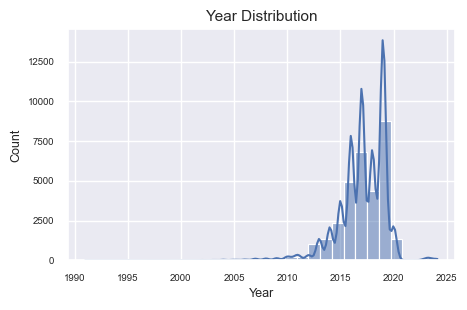

In [148]:
plt.figure(figsize=(5, 3))
sns.histplot(cars_test[cars_test['year'] > 0]['year'], bins=30, kde=True)
plt.xlabel("Year", fontsize=9)
plt.ylabel("Count", fontsize=9)
plt.title("Year Distribution", fontsize=11)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

In [146]:
year_mean_rounded = cars_test["year"].mean().astype(int)
year_median_rounded = cars_test["year"].median()
print(year_mean_rounded, year_median_rounded)

2017 2017.0


In [165]:
cars_test["year"].fillna(year_median_rounded)

carID
89856     2022.878006
106581    2017.000000
80886     2016.000000
100174    2019.000000
81376     2019.000000
             ...     
105775    2017.000000
81363     2020.000000
76833     2019.000000
91768     2019.000000
99627     2017.000000
Name: year, Length: 32567, dtype: float64

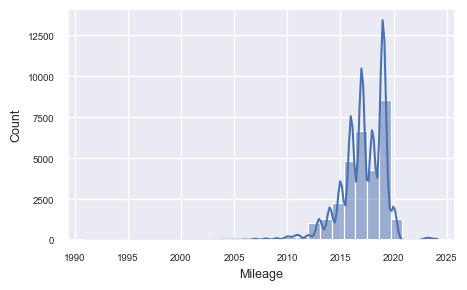

In [152]:
plt.figure(figsize=(5, 3))
sns.histplot(cars_test[cars_test['mileage'] > 0]['year'], bins=30, kde=True)
plt.xlabel("Mileage", fontsize=9)
plt.ylabel("Count", fontsize=9)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

# edu faz o codigo para preencher brands

In [120]:
print(cars_test.isna().sum())

Brand              649
model              650
year               653
transmission       623
mileage            689
fuelType           656
tax               3308
mpg               3288
engineSize         628
paintQuality%      625
previousOwners     597
hasDamage          597
dtype: int64


## Data types

In [ ]:
cars_test

In [ ]:
cars_test.isna().all(axis=1)


carID
89856     False
106581    False
80886     False
100174    False
81376     False
          ...  
105775    False
81363     False
76833     False
91768     False
99627     False
Length: 32567, dtype: bool

In [ ]:
#cars_test["year"] = cars_test["year"].astype(int)